In [218]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import GPyOpt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import distributions
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import ParameterSampler
import psutil
import random
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = [(225/255,102/255,102/255), (102/255,178/255,225/255),  (194/255,226/255,170/255), (225/255,178/255,102/255), (178/255,102/255,225/255),(225/255,225/255,102/255),(102/255,102/255,225/255)])

In [120]:
# The seed value
seed_value = 42

# 1. Set `torch` manual seed
torch.manual_seed(seed_value)

# 2. If using CUDA (for GPU operations)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # For multi-GPU setups

# 3. Set `numpy` seed
np.random.seed(seed_value)

# 4. Set `random` seed for Python
random.seed(seed_value)

# 5. Configure PyTorch to be deterministic (may impact performance)
# This is important for reproducibility when using certain CUDA operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [128]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


def load_data(batchsize):
    # Define a transform to normalize the data
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts a PIL image or numpy.ndarray to a tensor.
        transforms.Normalize((0.5,), (0.5,))  # Normalizes a tensor to have mean and standard deviation
    ])

    # Download and load the training data
    trainset = datasets.FashionMNIST('data/F_MNIST_data/', download=True, train=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False)

    # Download and load the test data
    testset = datasets.FashionMNIST('data/F_MNIST_data/', download=True, train=False, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=True)
    return trainloader, testloader


class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(7*7*64, 128)  # After pooling, the image size is 7x7
        self.fc2 = nn.Linear(128, 10)  # 10 output classes

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.25, training=self.training)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



def train_model(model, trainloader, learning_rate, device, optimizer_choice='Adam'):
    """
    Train a model on the FashionMNIST dataset.

    Parameters:
    - model: The neural network model to train.
    - trainloader: DataLoader for the training data.
    - learning_rate: Learning rate for the optimizer.
    - epochs: Number of epochs to train for.
    - optimizer_choice: Type of optimizer to use ('Adam', 'SGD', etc.).

    Returns:
    - A list of training losses per epoch.
    """
    
    # Optimizer choice
    if optimizer_choice == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_choice == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    else:
        raise ValueError("Unsupported optimizer choice")

    criterion = torch.nn.CrossEntropyLoss()
    train_losses = []

    # Training loop
    #for epoch in range(epochs):
    epoch = epoch_loss = 1
    
    while epoch_loss > 0.25 and epoch < 51:
        running_loss = 0
        for images, labels in trainloader:

            # Push to device
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(trainloader)
        train_losses.append(epoch_loss)

        # Print average loss for the epoch
        print(f'Epoch {epoch} - Training loss: {epoch_loss:.4f}')
        epoch += 1 

    return train_losses


def evaluate_model(model, dataloader, device, set='test', q=True):
    """
    Evaluate the trained model on the test set.

    Parameters:
    - model: The trained neural network model.
    - testloader: DataLoader for the test data.

    Returns:
    - The accuracy of the model on the test set.
    """
    
    # Ensure model is in evaluation mode
    model.eval()

    # Track the number of correct predictions and total number of images
    correct = 0
    total = 0

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for images, labels in dataloader:
            # Push to device
            images, labels = images.to(device), labels.to(device)

            # Forward pass to get outputs
            outputs = model(images)

            # Get the predicted class with the highest score
            _, predicted = torch.max(outputs.data, 1)

            # Update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = 100 * correct / total
    if not q:
        print(f'Model accuracy (on {set}): {accuracy:.2f}%')

    return accuracy


def visualize_train_loss(train_losses):
    plt.plot(train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid()
    plt.show()



def main(batchsize, device, q=True):
 
    print(f'Random search | Using device: {device}, Batchsize: {batchsize}')

    trainloader, testloader = load_data(batchsize=batchsize)

    # Create model
    model = FashionCNN()  
    model.to(device)

    # Train model and time it
    start_time = time.time()
    train_losses = train_model(model, trainloader, learning_rate=0.001, device=device, optimizer_choice='Adam')
    end_time = time.time()
    train_time = end_time - start_time
    # print(f"Batch size: {batchsize} | Time taken: {end_time - start_time:.2f} seconds")


    # Evaluating on train and test set for performance
    train_acc = evaluate_model(model, trainloader, device, "train", q=True)
    test_acc = evaluate_model(model, testloader, device, "test", q=True)

    if not q:
        visualize_train_loss(train_losses)

    return train_acc, test_acc, train_time

    # Function to train and evaluate the model
def train_and_evaluate(batch_size, device, accuracy_weight=0.5, time_weight=1):
    
    print(f'BOpt | Using device: {"mps" if device == 1 else "cpu"} | Batchsize {batch_size}')
    trainloader, testloader = load_data(batch_size)
    device = torch.device("mps" if device == 1 else "cpu")
    model = FashionCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Simplified training loop
    start_time = time.time()
    train_losses = []
    epoch = epoch_loss = 1
    
    while epoch_loss > 0.25 and epoch < 51: 
        model.train()
        running_loss = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(trainloader)
        train_losses.append(epoch_loss)

        # Print average loss for the epoch
        print(f'Epoch {epoch} - Training loss: {epoch_loss:.4f}')
        epoch += 1 

    # Training time
    train_time = time.time() - start_time
    # Evaluation
    model.eval()
    total = 0
    correct = 0
    
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    

    print(f'BOpt | Device: {device} | Batchsize: {batch_size} | Train time {train_time:.2f} seconds | Test accuracy {accuracy:.2f} | Ram used: {psutil.virtual_memory().used/1e9:.2f} gb \n')
    
    return train_time

# Objective function for GPyOpt
def objective_function(params):
    batch_size = int(params[0][0])
    device = int(params[0][1])  # 0 for cpu, 1 for mps/gpu
    return train_and_evaluate(batch_size, device)

In [129]:

start_time_Ran = time.time()
train_times = []
# initializing the best parameter found [0] is the training time [1] is device and [2] is batch size
best_param = [500, 0, 0]
max_oob_per_iteration = []

domain = {
        "batchsize" : np.arange(1,1025,1),
        "device" : (0,1)
}
param_list = list(ParameterSampler(domain, n_iter=20, random_state=32))
print('Param list for random search')
print(param_list)
print("\n")
iter = 1
for param in param_list:
        b = int(param["batchsize"])
        d = torch.device("mps" if param["device"] == 1 else "cpu")
        _, acc, train_time = main(batchsize=b, device=d)

        print(f'Random search | iteration {iter} | Device: {d} | Batchsize: {b} | Train time {train_time:.2f} seconds | Test accuracy {acc:.2f} | Ram used: {psutil.virtual_memory().used/1e9:.2f} gb \n')
        train_times.append(train_time)
        if train_time < best_param[0]:
                best_param[0] = train_time
                best_param[1] = d
                best_param[2] = b
        max_oob_per_iteration.append(best_param[0])
        iter += 1

total_time_Ran = time.time() - start_time_Ran
print(f"Random search | Best parameters: Device: {best_param[1]}, Batschsize: {best_param[2]} | Total time used: {total_time_Ran} \n")    
# for size, t in zip(batchsizes, train_times):
#     print(f'Batchsize: {size} | Train time {t}')

## define the domain of the considered parameters

# define the dictionary for GPyOpt
domain = [{'name': 'batchsizes', 'type': 'discrete', 'domain': tuple(np.arange(1,1025,1, dtype= 'int'))},
        {'name': 'device', 'type': 'categorical', 'domain': (0,1)}
]


## we have to define the function we want to maximize --> validation accuracy, 
## note it should take a 2D ndarray but it is ok that it assumes only one point
## in this setting
    

start_time_BO = time.time()
opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                                domain = domain,         # box-constrains of the problem
                                                acquisition_type = 'EI' ,      # Select acquisition function MPI, EI, LCB
                                                )
opt.acquisition.exploration_weight=0.5

opt.run_optimization(max_iter = 15) 

total_time_BO = time.time() - start_time_BO
x_best = opt.X[np.argmin(opt.Y)]
print("BOpt | The best parameters obtained: Batchsize:" + str(x_best[0]) + ", Device: " + "cpu" if x_best[1] == 0 else "mps" + " | Total time used: " + str(total_time_BO))

Param list for random search
[{'device': 1, 'batchsize': 364}, {'device': 1, 'batchsize': 790}, {'device': 1, 'batchsize': 963}, {'device': 0, 'batchsize': 668}, {'device': 0, 'batchsize': 447}, {'device': 0, 'batchsize': 992}, {'device': 0, 'batchsize': 45}, {'device': 1, 'batchsize': 714}, {'device': 0, 'batchsize': 127}, {'device': 1, 'batchsize': 548}, {'device': 0, 'batchsize': 256}, {'device': 1, 'batchsize': 301}, {'device': 1, 'batchsize': 898}, {'device': 1, 'batchsize': 499}, {'device': 0, 'batchsize': 630}, {'device': 1, 'batchsize': 5}, {'device': 0, 'batchsize': 515}, {'device': 1, 'batchsize': 838}, {'device': 1, 'batchsize': 233}, {'device': 1, 'batchsize': 642}]


Random search | Using device: mps, Batchsize: 364
Epoch 1 - Training loss: 0.7009
Epoch 2 - Training loss: 0.4435
Epoch 3 - Training loss: 0.3792
Epoch 4 - Training loss: 0.3412
Epoch 5 - Training loss: 0.3143
Epoch 6 - Training loss: 0.2946
Epoch 7 - Training loss: 0.2807
Epoch 8 - Training loss: 0.2665
Epoch

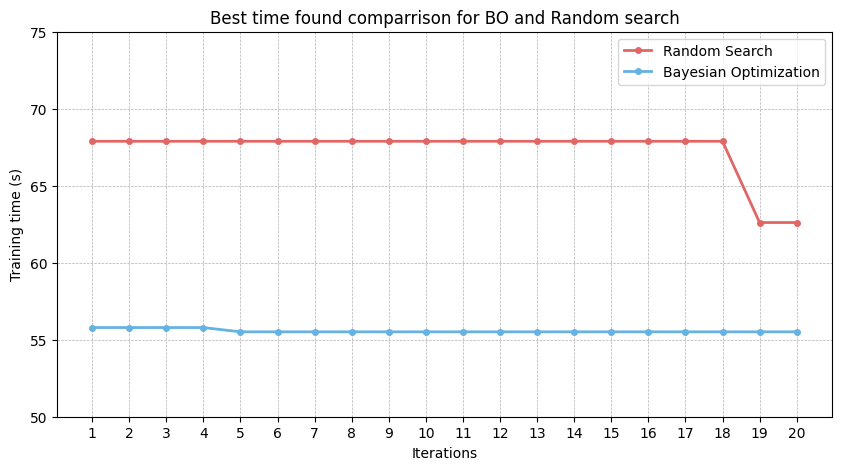

In [258]:
y_bo = -np.maximum.accumulate(-opt.Y).ravel()
# define iteration number
xs = np.arange(1,21,1)

plt.figure(figsize=(10, 5))
plt.plot(xs, max_oob_per_iteration, 'o-', color = (225/255,102/255,102/255), label='Random Search', linewidth = 2, markersize = 4)
plt.plot(xs, y_bo, 'o-', color = (102/255,178/255,225/255), label='Bayesian Optimization', linewidth = 2, markersize = 4)
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Training time (s)')
plt.title('Best time found comparrison for BO and Random search')
plt.ylim((50,75))
plt.xticks(xs)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [131]:
#We start by taking a look a the model subclass of our Bayesian optimization object
print(opt.model.input_dim)
#so there is 6 dimensions, that is 1 for each of n_estimators and depth which are discrete variables.
# the remaining 4 is because one-out-of-K encoding is using for the categorical variables max_features and criterion
#we can also look at kernel parameters
print(opt.model.get_model_parameters_names())
#and get the current fitted values
print(opt.model.get_model_parameters())

3
['GP_regression.Mat52.variance', 'GP_regression.Mat52.lengthscale', 'GP_regression.Gaussian_noise.variance']
[[8.34563331e+00 2.05893129e+02 1.43028727e-02]]


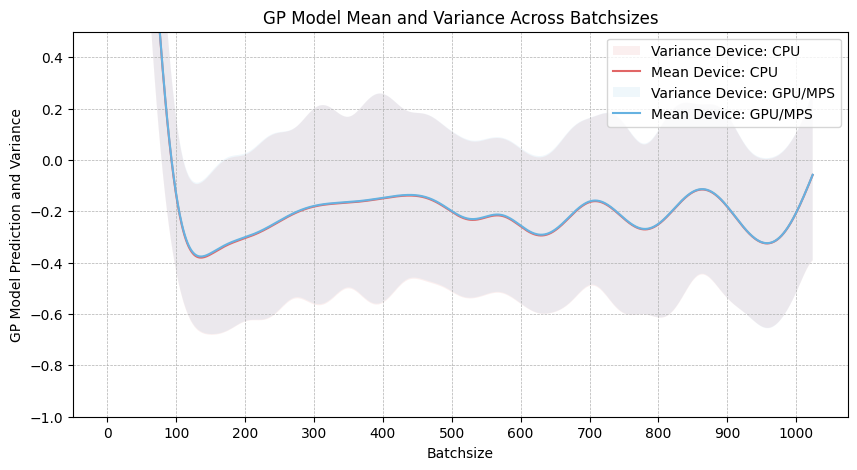

In [262]:
# Example setup
batchsize_range = np.arange(1, 1025, 1)  # Adjust as needed
device_settings = [0, 1]  # Assuming 0 for CPU and 1 for GPU/MPS
param3_fixed_value = 0.5  # Example fixed value for the third dimension

# Create figure with two subplots: one for the GP model's predictions and one for the acquisition function
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

for device_setting in device_settings:
    input_grid = np.zeros((len(batchsize_range), 3))
    input_grid[:, 0] = batchsize_range
    input_grid[:, 1] = device_setting
    input_grid[:, 2] = param3_fixed_value

    # Get mean and variance from the GP model
    mean, variance = opt.model.predict(input_grid)

    # Plot mean and variance on the first subplot
    axs.fill_between(batchsize_range, mean.flatten() - 2*variance.flatten(), mean.flatten() + 2*variance.flatten(), alpha=0.1,
                        label=f'Variance Device: {"CPU" if device_setting == 0 else "GPU/MPS"}')
    axs.plot(batchsize_range, mean.flatten(), label=f'Mean Device: {"CPU" if device_setting == 0 else "GPU/MPS"}')
    #axs.plot(min(mean))

# Configure the first subplot (GP model's predictions)
axs.set_xlabel('Batchsize')
axs.set_ylabel('GP Model Prediction and Variance')
axs.set_title('GP Model Mean and Variance Across Batchsizes')
axs.set_ylim((-1,0.5))
axs.grid(True, which='both', linestyle='--', linewidth=0.5)
axs.set_xticks(np.arange(0,1001,100))
axs.legend()

plt.show()


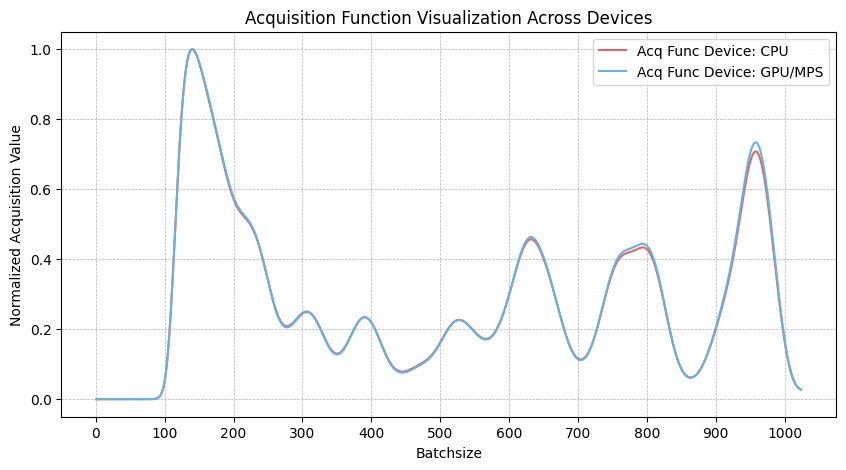

In [263]:
# Example setup
batchsize_range = np.arange(1, 1025, 1)  # Adjust as needed
device_settings = [0, 1]  # Assuming 0 for CPU and 1 for GPU/MPS
param3_fixed_value = 0.5  # Example fixed value for the third dimension

# Create figure with two subplots: one for the GP model's predictions and one for the acquisition function
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

for device_setting in device_settings:
    input_grid = np.zeros((len(batchsize_range), 3))
    input_grid[:, 0] = batchsize_range
    input_grid[:, 1] = device_setting
    input_grid[:, 2] = param3_fixed_value

    # Get mean and variance from the GP model
    mean, variance = opt.model.predict(input_grid)

    # Evaluate and normalize the acquisition function
    acq_values = opt.acquisition.acquisition_function(input_grid)
    acq_values_normalized = (acq_values - np.min(acq_values)) / (np.max(acq_values) - np.min(acq_values))

    # Plot acquisition function values on the second subplot
    axs.plot(batchsize_range, -acq_values_normalized + 1, label=f'Acq Func Device: {"CPU" if device_setting == 0 else "GPU/MPS"}')

# Configure the second subplot (Acquisition function)
axs.set_xlabel('Batchsize')
axs.set_ylabel('Normalized Acquisition Value')
axs.set_title('Acquisition Function Visualization Across Devices')
axs.grid(True, which='both', linestyle='--', linewidth=0.5)
axs.set_xticks(np.arange(0,1001,100))
axs.legend()

plt.show()

In [280]:
for i in acq_values:
    print(i)

[-2.77462841e-171]
[-5.60403563e-169]
[-1.09353812e-165]
[-1.620381e-161]
[-1.35490565e-156]
[-4.59567267e-151]
[-4.49770667e-145]
[-9.11884382e-139]
[-2.81896409e-132]
[-1.01319105e-125]
[-3.36377176e-119]
[-8.55275419e-113]
[-1.43888351e-106]
[-1.43688655e-100]
[-7.89631708e-95]
[-2.27616913e-89]
[-3.35549988e-84]
[-2.51097419e-79]
[-9.59769785e-75]
[-1.90476224e-70]
[-2.00954014e-66]
[-1.15948226e-62]
[-3.77537001e-59]
[-7.1691002e-56]
[-8.20841119e-53]
[-5.85703931e-50]
[-2.68948869e-47]
[-8.19651158e-45]
[-1.70723201e-42]
[-2.49848437e-40]
[-2.6366347e-38]
[-2.05555753e-36]
[-1.21086214e-34]
[-5.50314984e-33]
[-1.96727803e-31]
[-5.63120863e-30]
[-1.31207934e-28]
[-2.52650637e-27]
[-4.07699466e-26]
[-5.58463116e-25]
[-6.5707299e-24]
[-6.71302272e-23]
[-6.01523137e-22]
[-4.77106514e-21]
[-3.37823392e-20]
[-2.15212793e-19]
[-1.24244619e-18]
[-6.54338317e-18]
[-3.16303519e-17]
[-1.41136914e-16]
[-5.84364335e-16]
[-2.25597408e-15]
[-8.15710827e-15]
[-2.77390193e-14]
[-8.90570495e-14]
[

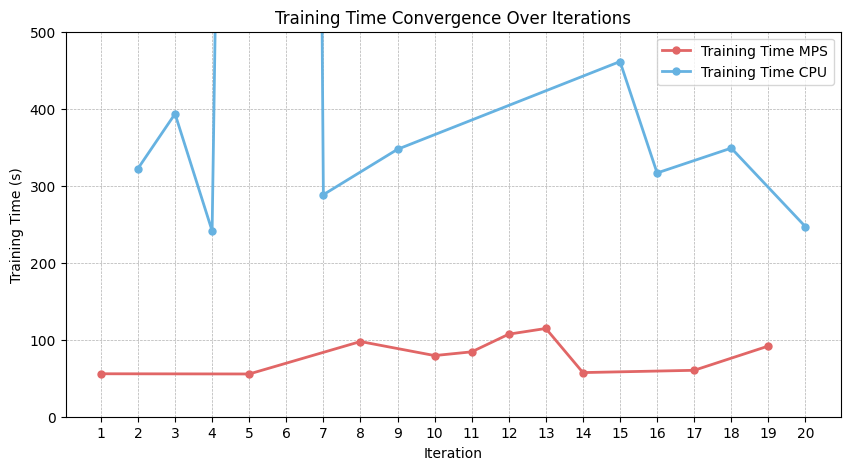

In [235]:


# Sample data based on the quotes from the text file
data = {
    'Iteration': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'Device': ['mps', 'cpu', 'cpu', 'cpu', 'mps', 'cpu', 'cpu', 'mps', 'cpu', 'mps', 'mps', 'mps', 'mps', 'mps', 'cpu', 'cpu', 'mps', 'cpu', 'mps', 'cpu'],
    'Batchsize': [103, 436, 861, 271, 107, 1, 350, 780, 705, 533, 607, 985, 930, 203, 1024, 489, 143, 570, 645, 121],
    'Training Time': [55.79, 322.32, 393.38, 241.30, 55.51, 6644.42, 288.36, 97.64, 347.32, 79.42, 84.27, 107.22, 114.61, 57.32, 461.28, 316.58, 60.29, 348.83, 91.79, 246.82]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 5))
for device in df['Device'].unique():
    subset = df[df['Device'] == device]
    plt.plot(subset['Iteration'], subset['Training Time'], marker='o', label=f'Training Time {device.upper()}', linewidth = 2, markersize = 5)

plt.xlabel('Iteration')
plt.ylabel('Training Time (s)')
plt.title('Training Time Over Iterations')
plt.xticks(data["Iteration"])
plt.legend()
plt.ylim((0,500))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


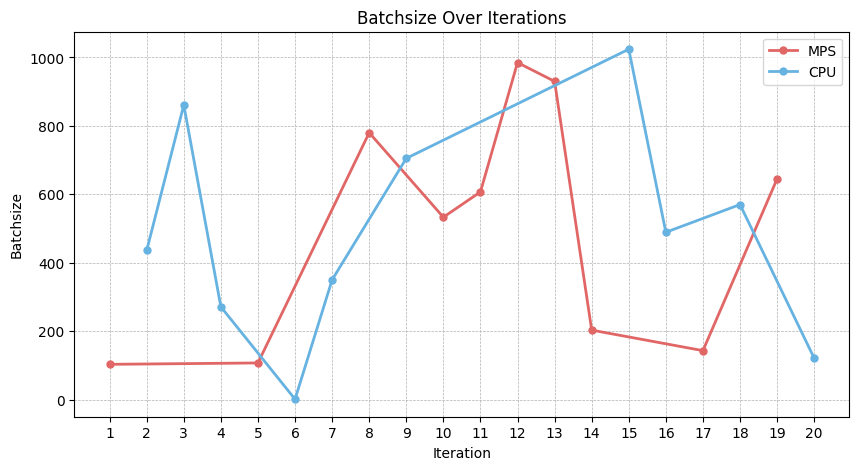

In [232]:
# Plotting

plt.figure(figsize=(10, 5))
for device in df['Device'].unique():
    subset = df[df['Device'] == device]
    plt.plot(subset['Iteration'], subset['Batchsize'], marker='o', label=f'{device.upper()}', linewidth = 2, markersize = 5)

plt.xlabel('Iteration')
plt.ylabel('Batchsize')
plt.title('Batchsize Over Iterations')
plt.xticks(data["Iteration"])
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [270]:
data["Training Time"][1]

322.32

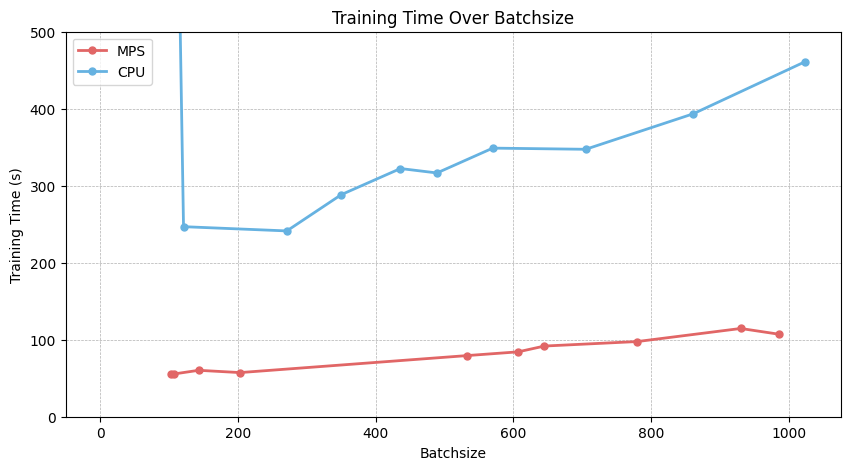

In [276]:
# Plotting

plt.figure(figsize=(10, 5))
for device in df['Device'].unique():
    # Select the subset for the current device
    subset = df[df['Device'] == device]
    # Sort the subset by 'Training Time' while keeping the pairing with 'Batchsize'
    sorted_subset = subset.sort_values(by='Batchsize')
    plt.plot(sorted_subset['Batchsize'], sorted_subset['Training Time'], marker='o', label=f'{device.upper()}' , linewidth = 2, markersize = 5)

plt.xlabel('Batchsize')
plt.ylabel('Training Time (s)')
plt.title('Training Time Over Batchsize')
plt.ylim((0,500))
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [277]:
3799/3622

1.048868028713418